In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta


from scipy.stats import ttest_ind, mannwhitneyu, spearmanr
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import (accuracy_score, precision_score, recall_score, roc_auc_score,
mean_squared_error, r2_score, mean_absolute_error)
import joblib

In [2]:
TRADER_PATH = '/content/historical_data.csv'
SENTIMENT_PATH = '/content/fear_greed_index.csv'

In [3]:
# loading the datasets
def load_data(trader_path=TRADER_PATH, sentiment_path=SENTIMENT_PATH):
    trader = pd.read_csv(trader_path, low_memory=False)
    sentiment = pd.read_csv(sentiment_path, low_memory=False)
    return trader, sentiment
trader, sentiment = load_data()

dt_candidates = ['time', 'timestamp', 'date', 'created_at']
for col in trader.columns:
    if col.lower() in dt_candidates and pd.api.types.is_object_dtype(trader[col]):
        try:
            trader[col] = pd.to_datetime(trader[col], errors='coerce')
        except Exception:
            pass

# sentiment datetime
for col in sentiment.columns:
    if col.lower() in ['date', 'timestamp', 'time', 'day']:
        try:
            sentiment[col] = pd.to_datetime(sentiment[col], errors='coerce')
        except Exception:
            pass

print('Trader columns:', trader.columns.tolist())
print('Sentiment columns:', sentiment.columns.tolist())

Trader columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']
Sentiment columns: ['timestamp', 'value', 'classification', 'date']


In [4]:
# checking basic about datasets
def quick_inspect(df, name, n=5):
    print(f"--- {name} ---")
    print('shape:', df.shape)
    print(df.head(n))
    print(df.info())


quick_inspect(trader, 'Trader')
quick_inspect(sentiment, 'Sentiment')

--- Trader ---
shape: (211224, 16)
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL                                   Transaction Hash     

In [5]:
# standarize columns
trader.columns = [c.strip() for c in trader.columns]
sentiment.columns = [c.strip() for c in sentiment.columns]

In [6]:
# checking the datetime in trader
if 'time' not in trader.columns: # Only create if not already there
    if 'Timestamp IST' in trader.columns:
        trader['time'] = pd.to_datetime(trader['Timestamp IST'], errors='coerce')
    elif 'Timestamp' in trader.columns:
        # Assuming 'Timestamp' (float) is Unix epoch in seconds
        trader['time'] = pd.to_datetime(trader['Timestamp'], unit='s', errors='coerce')
    else:
        print("Warning: No suitable timestamp column found in 'trader' to create 'time'.")

# Ensure 'time' column is datetime type if it exists
if 'time' in trader.columns and not np.issubdtype(trader['time'].dtype, np.datetime64):
    trader['time'] = pd.to_datetime(trader['time'], errors='coerce')

# In sentiment, choose a date column
sent_date_col = None
# Prioritize 'date' column if it exists, as it appears to contain the correct human-readable dates.
if 'date' in sentiment.columns:
    sent_date_col = 'date'
else:
    for c in sentiment.columns:
        if c.lower() in ['timestamp', 'time', 'day']:
            sent_date_col = c
            break

if sent_date_col is None:
    raise ValueError('No suitable date column found in sentiment data. Please check the CSV headers.')

# ensure datetime type for sentiment's chosen date column
sentiment[sent_date_col] = pd.to_datetime(sentiment[sent_date_col], errors='coerce')

In [7]:
# Drop rows with no timestamps (can't merge without)
trader = trader[~trader['time'].isna()].copy()
sentiment = sentiment[~sentiment[sent_date_col].isna()].copy()

In [8]:
# basic cleaning
col_map = {}
for c in trader.columns:
    lc = c.lower()
    if lc in ['account', 'acct', 'user']:
        col_map[c] = 'account'
    elif 'side' == lc:
        col_map[c] = 'side'
    elif lc == 'size tokens' or lc in ['size','qty','quantity']:
        col_map[c] = 'size'
    elif lc == 'execution price' or lc in ['price','execution_price','exec_price']:
        col_map[c] = 'price'
    elif lc == 'closed pnl' or lc in ['closedpnl','pnl','profit','realized_pnl']:
        col_map[c] = 'closedPnL'
    elif 'leverage' in lc:
        col_map[c] = 'leverage'
    elif lc in ['symbol','instrument','pair']:
        col_map[c] = 'symbol'

trader = trader.rename(columns=col_map)
print('Renamed cols (if matched):', col_map)

Renamed cols (if matched): {'Account': 'account', 'Execution Price': 'price', 'Size Tokens': 'size', 'Side': 'side', 'Closed PnL': 'closedPnL'}


In [9]:
# convert numeric columns
num_cols = ['size','price','closedPnL','leverage']
for c in num_cols:
    if c in trader.columns:
        trader[c] = pd.to_numeric(trader[c], errors='coerce')


# If closedPnL not present, try to compute from pnl columns
if 'closedPnL' not in trader.columns:
    # try to create pnl if we have entry/exit prices & size & side
    print('closedPnL not found; please ensure your trader dataset has realized PnL column.')

In [10]:
#  Create trade_date and sentiment date fields for merge
trader['trade_date'] = trader['time'].dt.date
sentiment['sent_date'] = sentiment[sent_date_col].dt.date


# lowercase classification column if exists
sentiment_cols_lower = {c: c.lower() for c in sentiment.columns}


# commonly 'classification' or 'value' or 'score'
sentiment_col_candidates = [c for c in sentiment.columns if c.lower() in ['classification','classification_label','label','value','score','sentiment','fear_greed']]
print('Sentiment candidates:', sentiment_col_candidates)


# pick likely numeric score column
score_col = None
for c in sentiment.columns:
    if c.lower() in ['score','value','fear_greed_score','index']:
        score_col = c
        break


# pick classification
class_col = None
for c in sentiment.columns:
    if c.lower() in ['classification','label','fear_greed_category','type','classification_label']:
        class_col = c
        break


print('Chosen score_col:', score_col, 'class_col:', class_col)

Sentiment candidates: ['value', 'classification']
Chosen score_col: value class_col: classification


In [15]:
#  Merge
merged = pd.merge(trader, sentiment, left_on='trade_date', right_on='sent_date', how='left', suffixes=('', '_sent'))
print('Merged shape:', merged.shape)

# Adjust score_col and class_col to reflect merged column names if suffixes were applied
if score_col and score_col not in merged.columns and (score_col + '_sent') in merged.columns:
    score_col = score_col + '_sent'
if class_col and class_col not in merged.columns and (class_col + '_sent') in merged.columns:
    class_col = class_col + '_sent'

# Quick check: percent of trades with sentiment filled
filled_pct = merged[score_col].notna().mean() if score_col else merged[class_col].notna().mean()
print(f"Fraction of trades with matching sentiment: {filled_pct:.3f}")

Merged shape: (79225, 23)
Fraction of trades with matching sentiment: 0.453


In [12]:
# 11. Feature engineering
# canonical features: is_long, notional, return_pct (if possible), win_flag
merged['is_long'] = False
if 'side' in merged.columns:
    merged['is_long'] = merged['side'].astype(str).str.lower().isin(['buy','long'])


# notional: absolute size * price
if 'size' in merged.columns and 'price' in merged.columns:
    merged['notional'] = (merged['size'].abs()) * merged['price']
else:
    merged['notional'] = np.nan


# return_pct: closedPnL / notional if available
if 'closedPnL' in merged.columns:
    merged['return_pct'] = merged['closedPnL'] / (merged['notional'].replace(0, np.nan))
    merged['win'] = (merged['closedPnL'] > 0)
else:
    merged['return_pct'] = np.nan
    merged['win'] = np.nan


# rolling sentiment (7-day) - need numeric score
if score_col:
    # ensure there are no duplicate dates in sentiment when calculating rolling
    sent_agg = sentiment.groupby('sent_date')[score_col].mean().reset_index()
    sent_agg['sent_date'] = pd.to_datetime(sent_agg['sent_date']).dt.date
    sent_agg = sent_agg.sort_values('sent_date')
    sent_agg['roll7'] = sent_agg[score_col].rolling(7,min_periods=1).mean()
    merged = pd.merge(merged, sent_agg[['sent_date', score_col, 'roll7']], on='sent_date', how='left')


# basic account-level aggregates (example)
agg_dict = {
    'total_trades': ('time','count'),
    'win_rate': ('win', lambda x: np.mean(x.dropna()) if x.notna().any() else np.nan),
}

if 'leverage' in merged.columns:
    agg_dict['avg_leverage'] = ('leverage', 'mean')
if 'notional' in merged.columns:
    agg_dict['avg_notional'] = ('notional','mean')
if 'closedPnL' in merged.columns:
    agg_dict['avg_pnl'] = ('closedPnL','mean')

acct_agg = merged.groupby('account').agg(**agg_dict).reset_index()

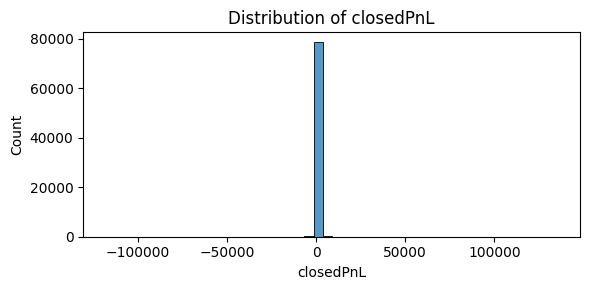

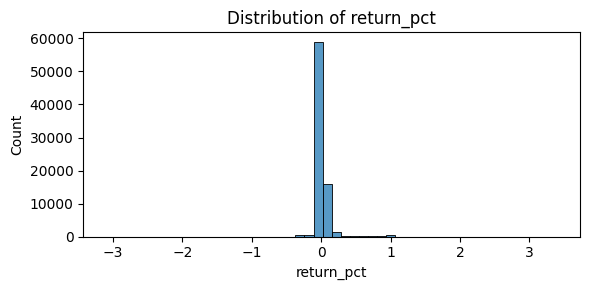

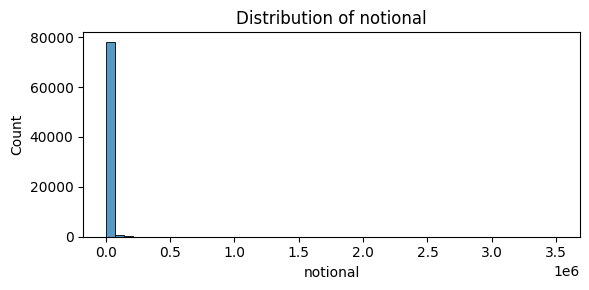

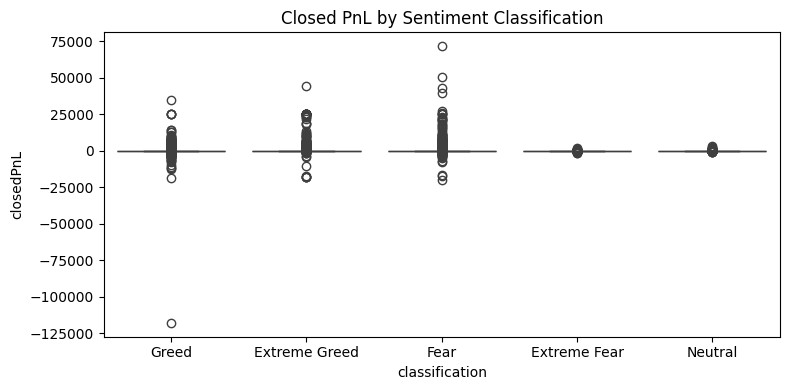

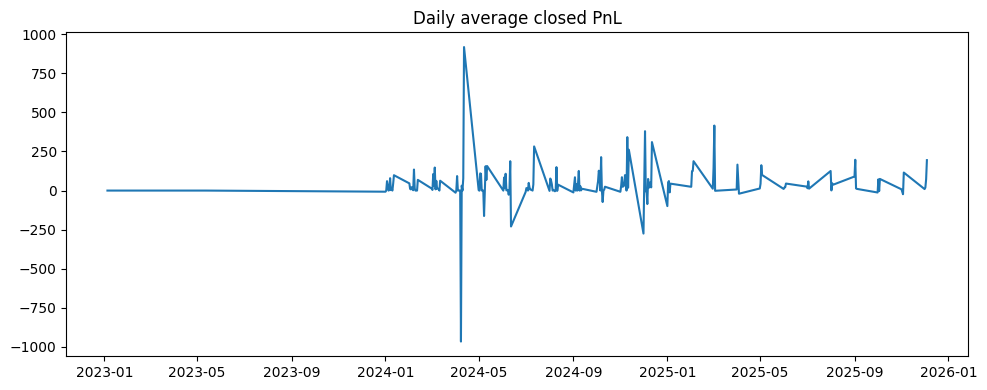

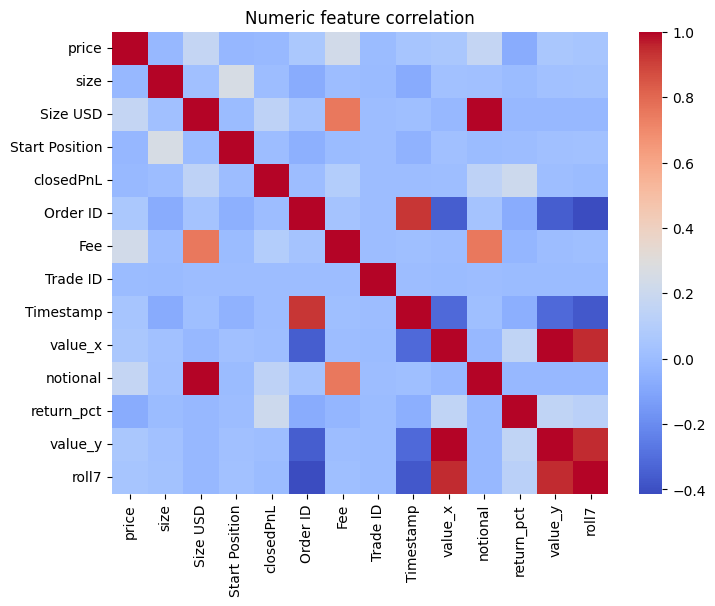

In [13]:
# EDA: distributions and visuals
def plot_histograms(df):
    num = ['closedPnL','return_pct','notional','leverage']
    present = [c for c in num if c in df.columns]
    for c in present:
        plt.figure(figsize=(6,3))
        sns.histplot(df[c].dropna(), bins=50)
        plt.title(f'Distribution of {c}')
        plt.tight_layout()
        plt.show()


plot_histograms(merged)


# PnL by sentiment classification
if class_col and class_col in merged.columns and 'closedPnL' in merged.columns:
    plt.figure(figsize=(8,4))
    sns.boxplot(data=merged, x=class_col, y='closedPnL')
    plt.title('Closed PnL by Sentiment Classification')
    plt.tight_layout()
    plt.show()


# Time series: daily avg pnl vs sentiment score
if 'trade_date' in merged.columns and 'closedPnL' in merged.columns:
    daily = merged.groupby('trade_date').agg(daily_avg_pnl=('closedPnL','mean'), daily_trades=('closedPnL','count')).reset_index()
    daily['trade_date'] = pd.to_datetime(daily['trade_date'])
    plt.figure(figsize=(10,4))
    plt.plot(daily['trade_date'], daily['daily_avg_pnl'])
    plt.title('Daily average closed PnL')
    plt.tight_layout()
    plt.show()


# Correlation heatmap for numeric features
numdf = merged.select_dtypes(include=[np.number])
if not numdf.empty:
    corr = numdf.corr()
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=False, cmap='coolwarm')
    plt.title('Numeric feature correlation')
    plt.show()

In [16]:
# Statistical tests
if class_col and class_col in merged.columns and 'closedPnL' in merged.columns:
    groups = merged[[class_col, 'closedPnL']].dropna()
    greed = groups[groups[class_col].str.lower().str.contains('greed', na=False)]['closedPnL']
    fear = groups[groups[class_col].str.lower().str.contains('fear', na=False)]['closedPnL']
    if len(greed) > 20 and len(fear) > 20:
        tstat, pval = ttest_ind(greed, fear, equal_var=False, nan_policy='omit')
        mwu_stat, mwu_p = mannwhitneyu(greed, fear)
        print('t-test: t=%.3f p=%.5f' % (tstat, pval))
        print('Mann-Whitney U: stat=%.3f p=%.5f' % (mwu_stat, mwu_p))
    else:
        print('Not enough samples in Greed or Fear groups for robust t-test')


# Spearman correlation between numeric sentiment score and daily avg pnl
if score_col:
    daily_sent = merged.groupby('trade_date').agg(daily_avg_pnl=('closedPnL','mean'), sent_score=(score_col,'mean')).reset_index().dropna()
    if len(daily_sent) > 10:
        rho, p_s = spearmanr(daily_sent['sent_score'], daily_sent['daily_avg_pnl'])
        print('Spearman rho=%.3f p=%.5f' % (rho, p_s))

t-test: t=-0.366 p=0.71423
Mann-Whitney U: stat=151129655.000 p=0.00000
Spearman rho=0.049 p=0.53740


In [18]:
# Predictive models
model_df = merged.copy()
model_df['profit_flag'] = (model_df['closedPnL'] > 0).astype(int) if 'closedPnL' in model_df.columns else np.nan


features = []
# candidate features
for f in ['price','size','notional','leverage','is_long']:
    if f in model_df.columns:
        features.append(f)
if score_col:
    features.append(score_col)


features = list(set(features))
print('Model features:', features)


# drop na in features
model_df = model_df.dropna(subset=features + ['profit_flag'])


# simple train/test split, time-ordered (no shuffling)
if not model_df.empty and len(model_df) > 100:
    tss = TimeSeriesSplit(n_splits=5)
    X = model_df[features]
    y = model_df['profit_flag']
    # simple train-test split maintaining order
    split_idx = int(len(X)*0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]


    # scale numeric features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train.select_dtypes(include=[np.number]))
    X_test_scaled = scaler.transform(X_test.select_dtypes(include=[np.number]))


    # use a random forest classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train.fillna(0), y_train)
    ypred = clf.predict(X_test.fillna(0))
    print('Accuracy:', accuracy_score(y_test, ypred))
    print('Precision:', precision_score(y_test, ypred, zero_division=0))
    print('Recall:', recall_score(y_test, ypred, zero_division=0))
    if hasattr(clf, 'predict_proba'):
        print('AUC (approx):', roc_auc_score(y_test, clf.predict_proba(X_test.fillna(0))[:,1]))


    # feature importance
    importances = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    print('Feature importances:\n', importances.head(10))

Model features: ['size', 'price', 'value']
Accuracy: 0.6418513871462429
Precision: 0.6371708511941212
Recall: 0.6005772005772005
AUC (approx): 0.6936527783615162
Feature importances:
 price    0.566075
size     0.283508
value    0.150417
dtype: float64


In [21]:
# advance checks
if score_col and 'trade_date' in merged.columns and 'closedPnL' in merged.columns:
    daily = merged.groupby('trade_date').agg(daily_avg_pnl=('closedPnL','mean'), sent_score=(score_col,'mean')).reset_index()
    daily['trade_date'] = pd.to_datetime(daily['trade_date'])
    daily = daily.sort_values('trade_date')
    daily['sent_lag1'] = daily['sent_score'].shift(1)
    daily = daily.dropna()
    rho, p_s = spearmanr(daily['sent_lag1'], daily['daily_avg_pnl'])
    print('Lagged Sentiment (t-1) vs daily_avg_pnl: spearman rho=%.3f p=%.5f' % (rho, p_s))


# 15B: Clustering accounts by behavior
cluster_df = acct_agg.dropna(subset=['total_trades'])
if len(cluster_df) >= 10:
    # choose features for clustering dynamically
    cluster_features = ['win_rate', 'avg_pnl']
    if 'avg_leverage' in cluster_df.columns:
        cluster_features.append('avg_leverage')
    if 'avg_notional' in cluster_df.columns:
        cluster_features.append('avg_notional')

    # only proceed if there are features to cluster on
    if cluster_features:
        Xc = cluster_df[cluster_features].fillna(0)
        # scale
        scaler = StandardScaler()
        Xc_s = scaler.fit_transform(Xc)
        kmeans = KMeans(n_clusters=3, random_state=42)
        cluster_df['cluster'] = kmeans.fit_predict(Xc_s)
        print(cluster_df[['account','cluster']].head())
    else:
        print("Not enough features available for clustering after aggregation.")

Lagged Sentiment (t-1) vs daily_avg_pnl: spearman rho=-0.003 p=0.96860
                                      account  cluster
0  0x083384f897ee0f19899168e3b1bec365f52a9012        0
1  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd        1
2  0x271b280974205ca63b716753467d5a371de622ab        0
3  0x28736f43f1e871e6aa8b1148d38d4994275d72c4        1
4  0x2c229d22b100a7beb69122eed721cee9b24011dd        1


In [23]:
#  Save outputs
os.makedirs('/mnt/data/output', exist_ok=True)
merged.to_csv('/mnt/data/output/merged_trader_sentiment.csv', index=False)
acct_agg.to_csv('/mnt/data/output/account_aggregates.csv', index=False)


# save model and scaler if trained
try:
    joblib.dump(clf, '/mnt/data/output/rf_profit_classifier.joblib')
    print('Saved model to /mnt/data/output/rf_profit_classifier.joblib')
except Exception:
    pass

Saved model to /mnt/data/output/rf_profit_classifier.joblib


In [26]:
# short summary
def generate_summary(merged, acct_agg, output_path='/mnt/data/output/summary.txt'):
    lines = []
    lines.append('Executive summary:')
    # basic signal: mean pnl by sentiment
    if class_col and 'closedPnL' in merged.columns:
        mean_by_class = merged.groupby(class_col)['closedPnL'].mean().sort_values(ascending=False)
        lines.append('Mean closedPnL by sentiment:')
        lines.extend([f" {idx}: {val:.4f}" for idx,val in mean_by_class.items()])
    else:
        lines.append('No classification/closedPnL available to summarize.')
    lines.append('\nTop account aggregates (sample):')
    lines.extend(acct_agg.head(5).to_string().splitlines())


    with open(output_path, 'w') as f:
        f.write('\n'.join(lines))
    print('Summary written to', output_path)


generate_summary(merged, acct_agg)

Summary written to /mnt/data/output/summary.txt


In [28]:
import os

output_dir = '/mnt/data/output/'
print("Files in output directory:")
for filename in os.listdir(output_dir):
    print(filename)

Files in output directory:
account_aggregates.csv
merged_trader_sentiment.csv
rf_profit_classifier.joblib
summary.txt


In [29]:
import pandas as pd

merged_df = pd.read_csv('/mnt/data/output/merged_trader_sentiment.csv')
print("\n--- Content of merged_trader_sentiment.csv (first 5 rows) ---")
display(merged_df.head())

acct_agg_df = pd.read_csv('/mnt/data/output/account_aggregates.csv')
print("\n--- Content of account_aggregates.csv (first 5 rows) ---")
display(acct_agg_df.head())


--- Content of merged_trader_sentiment.csv (first 5 rows) ---


,account,Coin,price,size,Size USD,side,Timestamp IST,Start Position,Direction,closedPnL,...,Fee,Trade ID,Timestamp,time,trade_date,timestamp,value,classification,date,sent_date
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,...,0.345404,8.950000e+14,1.730000e+12,2024-02-12 22:50:00,2024-02-12,1970-01-01 00:00:01.707715800,70.0,Greed,2024-02-12,2024-02-12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,...,0.005600,4.430000e+14,1.730000e+12,2024-02-12 22:50:00,2024-02-12,1970-01-01 00:00:01.707715800,70.0,Greed,2024-02-12,2024-02-12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,...,0.050431,6.600000e+14,1.730000e+12,2024-02-12 22:50:00,2024-02-12,1970-01-01 00:00:01.707715800,70.0,Greed,2024-02-12,2024-02-12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,...,0.050043,1.080000e+15,1.730000e+12,2024-02-12 22:50:00,2024-02-12,1970-01-01 00:00:01.707715800,70.0,Greed,2024-02-12,2024-02-12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,...,0.003055,1.050000e+15,1.730000e+12,2024-02-12 22:50:00,2024-02-12,1970-01-01 00:00:01.707715800,70.0,Greed,2024-02-12,2024-02-12



--- Content of account_aggregates.csv (first 5 rows) ---


,account,total_trades,win_rate,avg_notional,avg_pnl
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2712,0.435472,16559.604409,501.263878
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,1730,0.468786,2016.924512,3.117217
2,0x271b280974205ca63b716753467d5a371de622ab,1140,0.431579,10937.582128,26.473461
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,4306,0.461217,448.914980,9.598132
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,896,0.531250,2599.985844,85.182721


In [30]:
print("\n--- Content of summary.txt ---")
with open('/mnt/data/output/summary.txt', 'r') as f:
    print(f.read())


--- Content of summary.txt ---
Executive summary:
Mean closedPnL by sentiment:
 Extreme Greed: 205.8163
 Fear: 128.2880
 Greed: 53.9880
 Neutral: 27.0888
 Extreme Fear: 1.8916

Top account aggregates (sample):
                                      account  total_trades  win_rate  avg_notional     avg_pnl
0  0x083384f897ee0f19899168e3b1bec365f52a9012          2712  0.435472  16559.604409  501.263878
1  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd          1730  0.468786   2016.924512    3.117217
2  0x271b280974205ca63b716753467d5a371de622ab          1140  0.431579  10937.582128   26.473461
3  0x28736f43f1e871e6aa8b1148d38d4994275d72c4          4306  0.461217    448.914980    9.598132
4  0x2c229d22b100a7beb69122eed721cee9b24011dd           896  0.531250   2599.985844   85.182721


In [31]:
import joblib

loaded_model = joblib.load('/mnt/data/output/rf_profit_classifier.joblib')
print("\n--- Loaded Machine Learning Model (type) ---")
print(type(loaded_model))


--- Loaded Machine Learning Model (type) ---
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
